In [1]:
%load_ext autoreload
%autoreload 2

# LOW MULTICOLLINEARITY

## `cuML` Implementation - GPU Machine Learning Algorithms

[Source](https://github.com/rapidsai/cuml)

"cuML is a suite of libraries that implement machine learning algorithms and mathematical primitives functions that share compatible APIs with other RAPIDS projects.

cuML enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs without going into the details of CUDA programming. In most cases, cuML's Python API matches the API from scikit-learn."


Why do I want to implement this? because, the normal version takes above two hourse to run. 

In [2]:
import sys
sys.path.append('../../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

import cudf
import cupy as cp

from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from cuml.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support


from IPython.core.debugger import Pdb #Pdb().set_trace()


pd.set_option('display.max_columns', None)
path = "../../data/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Setting Features of Interest and Treatment to Categorical and Numerical Data

In [4]:
# Low Multicollinearity Features
features  =  ['BEIMHD', 'BETASTAR', 'BT', 'DWDIA', 'ELMFREQ', 'IP', 'NEL', 'NESOL', 'NUSTAR',
              'PECRH', 'PFLOSS', 'PICRH', 'POHM', 'PRAD', 'Q95', 'RHOSTAR', 'TIV', 'TORQ',
              'WFFORM', 'WFICFORM', 'ZEFF', 'ZEFFNEO']

In [5]:
DB5 = tokamakTK.clean_categorical_data(DB5)

# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]


data_num = tokamakTK.clean_numerical_data(data_num)


data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1)

This is what I had before to join comlumns.

```Python
DB5_ = pd.DataFrame(StandardScaler().fit_transform( DB5[num_features] ), columns = num_features)
data = pd.concat([DB5_,DB5[categorical]], axis=1, join="inner")
```

In [6]:
X = cudf.DataFrame(data_.drop("label", axis="columns"))
y = cudf.Series( data_["label"] )

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

# Convert cuDF dataframes to cuPy arrays
X_train_cupy = X_train.astype('float32').to_cupy().get()
y_train_cupy = y_train.astype('float32').to_cupy().get()

In [7]:
# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [270, 300, 400],
    'max_depth': [None, 20, 30],
#   'min_samples_split': [1, 2, 3],
#    'min_samples_leaf': [1, 2, 3],
#    'min_samples_split':[2,4,6,8],
#    'split_criterion':[0,1],
    'n_bins':[200, 225, 250, 300],
#    'max_features': ['sqrt', len(features)]
}


rf = RandomForestClassifier(min_samples_leaf=1,
                           min_samples_split=2,
                           random_state=71,
                           split_criterion=0,
                           max_features=len(features)
                           )
grid_search = GridSearchCV(rf, 
                           param_grid, 
                           cv= 10, #StratifiedKFold(n_splits=10, shuffle=True, random_state=71), 
                           scoring='recall', 
                           n_jobs=1, 
                           refit=True
                          )
# Fit the GridSearchCV object to your training data
grid_search.fit(X_train_cupy, y_train_cupy)


# Takes less than 10 min to run

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/kchinas/miniconda3/envs/thesis/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Rand

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'max_depth': [None, 20, 30],
                         'n_bins': [200, 225, 250, 300],
                         'n_estimators': [270, 300, 400]},
             scoring='recall')

In [8]:
# Get the best hyperparameters and best model from the GridSearchCV
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model on the entire training set
best_model.fit(X_train_cupy, y_train_cupy)

# Make predictions on the test set
y_pred = best_model.predict_proba(X_val)

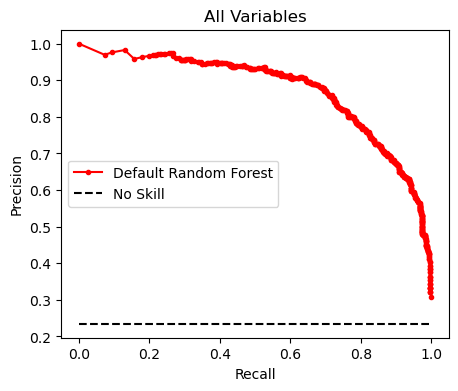

In [9]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
# plot the roc curve for the model
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot(recall, precision, marker='.', label='Default Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("All Variables")
plt.legend();

In [10]:
y_pred_ = best_model.predict(X_val)
precision_recall_fscore_support(y_val.to_numpy(), y_pred_.to_numpy(), labels=[1,0])

(array([0.8381201 , 0.92024129]),
 array([0.72954545, 0.95679443]),
 array([0.7800729 , 0.93816194]),
 array([ 440, 1435]))

In [11]:
best_params

{'max_depth': 20, 'n_bins': 200, 'n_estimators': 400}

In [12]:
import chime
chime.success()